In [110]:
import sys 
import os 
import pickle
import random
import numpy as np 
from astropy.io import fits
from astropy.coordinates import SkyCoord  
import astropy.units as u
import matplotlib.pylab as plt 
import pandas as pd 
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d

# plt.rc('text', usetex=True) # - Imperial cluster cannot find Latex
# plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
# figSize  = (12, 8)
# fontSize = 20

In [111]:
from configuration import get_config
CONFIG = get_config('KiDS-1000')

# Notes
Important columns identified in the catalogue.

## Positions on the sky
- ALPHA_J2000 (deg)
- DELTA_J2000 (deg)

## Ellipticities and Weights
- e1
- e2
- weight

## Flux
- FLUX_GAAP_u (count)
- FLUX_GAAP_g (count)
- FLUX_GAAP_r (count)
- FLUX_GAAP_i (count)
- FLUX_GAAP_Z (count)
- FLUX_GAAP_Y (count)
- FLUX_GAAP_J (count)
- FLUX_GAAP_H (count)
- FLUX_GAAP_Ks (count)

## Flux Errors
- FLUXERR_GAAP_u (count)
- FLUXERR_GAAP_g (count)
- FLUXERR_GAAP_r (count)
- FLUXERR_GAAP_i (count)
- FLUXERR_GAAP_Z (count)
- FLUXERR_GAAP_Y (count)
- FLUXERR_GAAP_J (count)
- FLUXERR_GAAP_H (count)
- FLUXERR_GAAP_Ks (count)

## Magnitude
- MAG_GAAP_u (mag)
- MAG_GAAP_g (mag)
- MAG_GAAP_r (mag)
- MAG_GAAP_i (mag)
- MAG_GAAP_Z (mag)
- MAG_GAAP_Y (mag)
- MAG_GAAP_J (mag)
- MAG_GAAP_H (mag)
- MAG_GAAP_Ks (mag)

## Magnitude Error
- MAGERR_GAAP_u (mag)
- MAGERR_GAAP_g (mag)
- MAGERR_GAAP_r (mag)
- MAGERR_GAAP_i (mag)
- MAGERR_GAAP_Z (mag)
- MAGERR_GAAP_Y (mag)
- MAGERR_GAAP_J (mag)
- MAGERR_GAAP_H (mag)
- MAGERR_GAAP_Ks (mag)

## Magnitude Limit
- MAG_LIM_u (mag)
- MAG_LIM_g (mag)
- MAG_LIM_r (mag)
- MAG_LIM_i (mag)
- MAG_LIM_Z (mag)
- MAG_LIM_Y (mag)
- MAG_LIM_J (mag)
- MAG_LIM_H (mag)
- MAG_LIM_Ks (mag)

## Flag (all of them 0)
- FLAG_GAAP_u
- FLAG_GAAP_g
- FLAG_GAAP_r
- FLAG_GAAP_i
- FLAG_GAAP_Z
- FLAG_GAAP_Y
- FLAG_GAAP_J
- FLAG_GAAP_H
- FLAG_GAAP_Ks

## BPZ
- M_0 (reference magnitude for BPZ prior)
- Z_B (9 band BPZ redshift estimate - peak of posterior)
- Z_ML (9 band BPZ maximum likelihood redshift)
- Z_B_MIN (lower bound of the 68% confidence interval of Z_B)
- Z_B_MAX (upper bound of the 68% confidence interval of Z_B)

# Plot Objects on the Sky

We have chosen the first 500 000 objects in the catalogue. Takes a long time to plot all the samples. 

In [112]:
fits_image = fits.open('./data/catalogue/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits')
data = fits_image[1].data
fits_image.close()

## Redshifts

In [113]:
rednames = ['Z_B', 'Z_ML']
redshifts = np.asarray([data[rednames[i]] for i in range(len(rednames))]).T
df_redshifts = pd.DataFrame(redshifts, columns = rednames, dtype = np.float16)

In [114]:
df_redshifts.head()

,Z_B,Z_ML
0,0.709961,0.070007
1,0.439941,0.439941
2,1.080078,1.089844
3,0.540039,0.700195
4,1.009766,1.030273


## Names 

In [115]:
names = np.asarray(data['THELI_NAME'], dtype = str)
df_names = pd.DataFrame(names, columns = ['THELI_NAME'])

## Fluxes

In [116]:
fluxes = np.asarray([data[CONFIG.colnames.flux[i]] for i in range(CONFIG.nband)]).T
df_flux = pd.DataFrame(fluxes, columns=CONFIG.colnames.flux, dtype=np.float32)

In [117]:
df_flux.head()

,FLUX_GAAP_u,FLUX_GAAP_g,FLUX_GAAP_r,FLUX_GAAP_i,FLUX_GAAP_Z,FLUX_GAAP_Y,FLUX_GAAP_J,FLUX_GAAP_H,FLUX_GAAP_Ks
0,1.056200e-11,1.392500e-10,1.615300e-10,2.616000e-10,316.019989,557.820007,221.858902,905.090027,924.590027
1,6.060100e-11,8.435300e-10,4.170800e-09,7.162000e-09,11010.000000,14520.000000,18281.925781,24005.000000,27658.000000
2,1.579000e-10,3.678500e-10,6.326800e-10,8.714600e-10,1914.500000,1557.099976,2037.095947,2146.000000,5169.600098
3,2.215500e-10,1.250500e-10,2.747600e-10,2.562200e-10,474.690002,890.419983,382.773987,2217.699951,856.369995
4,1.051100e-10,2.209900e-10,5.564200e-10,1.192700e-09,2096.135986,2520.406494,4021.867676,6219.298828,9032.557617


## Flux Error

In [118]:
flux_err_names = [f'FLUXERR_GAAP_{f}' for f in CONFIG.band]
flux_err = np.asarray([data[flux_err_names[i]] for i in range(CONFIG.nband)]).T
df_flux_err = pd.DataFrame(flux_err, columns=flux_err_names, dtype=np.float32)

In [119]:
df_flux_err.head()

,FLUXERR_GAAP_u,FLUXERR_GAAP_g,FLUXERR_GAAP_r,FLUXERR_GAAP_i,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks
0,6.540000e-11,2.810000e-11,3.120000e-11,7.300000e-11,161.000000,381.000000,424.805298,1030.000000,943.000000
1,7.250000e-11,3.210000e-11,3.710000e-11,8.580000e-11,178.000000,428.000000,481.546692,1200.000000,1100.000000
2,6.910000e-11,3.020000e-11,3.450000e-11,8.000000e-11,170.000000,407.000000,455.338013,1130.000000,1030.000000
3,6.620000e-11,2.860000e-11,3.220000e-11,7.520000e-11,164.000000,390.000000,382.330353,1060.000000,971.000000
4,5.290000e-11,2.640000e-11,2.930000e-11,6.770000e-11,120.152008,280.437103,275.078003,886.384155,702.218994


## Magnitude

In [120]:
mag = np.asarray([data[CONFIG.colnames.mag[i]] for i in range(CONFIG.nband)]).T
df_mag = pd.DataFrame(mag, columns=CONFIG.colnames.mag, dtype=np.float16)

In [121]:
df_mag.head()

,MAG_GAAP_u,MAG_GAAP_g,MAG_GAAP_r,MAG_GAAP_i,MAG_GAAP_Z,MAG_GAAP_Y,MAG_GAAP_J,MAG_GAAP_H,MAG_GAAP_Ks
0,99.00000,24.546875,24.421875,23.921875,23.718750,23.093750,24.109375,22.59375,22.578125
1,99.00000,22.593750,20.890625,20.328125,19.859375,19.562500,19.328125,19.03125,18.890625
2,24.40625,23.500000,22.937500,22.625000,21.750000,21.984375,21.703125,21.65625,20.703125
3,24.03125,24.671875,23.843750,23.953125,23.265625,22.593750,23.515625,21.62500,22.656250
4,24.81250,24.031250,23.062500,22.265625,21.640625,21.453125,20.968750,20.50000,20.093750


In [122]:
df_mag.max()

MAG_GAAP_u     99.0
MAG_GAAP_g     99.0
MAG_GAAP_r     99.0
MAG_GAAP_i     99.0
MAG_GAAP_Z     99.0
MAG_GAAP_Y     99.0
MAG_GAAP_J     99.0
MAG_GAAP_H     99.0
MAG_GAAP_Ks    99.0
dtype: float16

In [123]:
df_mag.min()

MAG_GAAP_u     17.062500
MAG_GAAP_g     17.859375
MAG_GAAP_r     16.796875
MAG_GAAP_i     16.343750
MAG_GAAP_Z     15.851562
MAG_GAAP_Y     15.664062
MAG_GAAP_J     14.992188
MAG_GAAP_H     14.015625
MAG_GAAP_Ks    15.734375
dtype: float16

## Magnitude Error

In [124]:
magerr_names = [f'MAGERR_GAAP_{f}' for f in CONFIG.band]
magerr = np.asarray([data[magerr_names[i]] for i in range(CONFIG.nband)]).T
df_magerr = pd.DataFrame(magerr, columns = magerr_names, dtype=np.float16)

In [125]:
df_magerr.head()

,MAGERR_GAAP_u,MAGERR_GAAP_g,MAGERR_GAAP_r,MAGERR_GAAP_i,MAGERR_GAAP_Z,MAGERR_GAAP_Y,MAGERR_GAAP_J,MAGERR_GAAP_H,MAGERR_GAAP_Ks
0,6.722656,0.219116,0.209717,0.302979,0.553223,0.741699,2.078125,1.235352,1.107422
1,1.298828,0.041321,0.009659,0.013008,0.017548,0.032013,0.028595,0.054260,0.043182
2,0.475098,0.089111,0.059204,0.099670,0.096436,0.283691,0.242676,0.571777,0.216309
3,0.324463,0.248291,0.127197,0.318604,0.375000,0.475586,1.084961,0.519043,1.231445
4,0.546387,0.129761,0.057159,0.061615,0.062225,0.120789,0.074280,0.154785,0.084412


## Extinction

In [126]:
ext_names = [f'EXTINCTION_{f}' for f in CONFIG.band]
extinction = np.asarray([data[ext_names[i]] for i in range(CONFIG.nband)]).T
df_ext = pd.DataFrame(extinction, columns = ext_names, dtype=np.float16)

In [127]:
df_ext.head()

,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,EXTINCTION_Z,EXTINCTION_Y,EXTINCTION_J,EXTINCTION_H,EXTINCTION_Ks
0,0.130981,0.102051,0.070618,0.052460,0.039032,0.033661,0.021866,0.013885,0.009300
1,0.131714,0.102600,0.070984,0.052765,0.039246,0.033844,0.021988,0.013962,0.009354
2,0.131958,0.102844,0.071167,0.052856,0.039337,0.033905,0.022034,0.013992,0.009369
3,0.132568,0.103271,0.071411,0.053101,0.039490,0.034058,0.022125,0.014046,0.009407
4,0.162598,0.126709,0.087646,0.065125,0.048431,0.041779,0.027145,0.017227,0.011543


## Magnitude Limit

In [128]:
mag_lim_names = [f'MAG_LIM_{f}' for f in CONFIG.band]
mag_lim = np.asarray([data[mag_lim_names[i]] for i in range(CONFIG.nband)]).T
df_mag_lim = pd.DataFrame(mag_lim, columns = mag_lim_names, dtype=np.float16)

In [129]:
df_mag_lim.head()

,MAG_LIM_u,MAG_LIM_g,MAG_LIM_r,MAG_LIM_i,MAG_LIM_Z,MAG_LIM_Y,MAG_LIM_J,MAG_LIM_H,MAG_LIM_Ks
0,25.500000,26.390625,26.281250,25.359375,24.484375,23.546875,23.421875,22.468750,22.562500
1,25.390625,26.250000,26.093750,25.187500,24.375000,23.421875,23.296875,22.296875,22.390625
2,25.437500,26.312500,26.171875,25.265625,24.421875,23.468750,23.359375,22.375000,22.468750
3,25.484375,26.375000,26.250000,25.328125,24.468750,23.515625,23.546875,22.437500,22.531250
4,25.734375,26.453125,26.343750,25.453125,24.796875,23.875000,23.906250,22.625000,22.890625


# Check for Negative Values

In [130]:
np.any(df_mag.values < 0)

False

In [131]:
np.any(df_flux.values < 0)

True

In [132]:
np.any(df_flux_err.values < 0)

False

# Processing

In [133]:
NOBJECTS = 5000

In [134]:
test_mag = df_mag.iloc[0:NOBJECTS].copy()
test_magerr = df_magerr.iloc[0:NOBJECTS].copy()
test_maglim = df_mag_lim.iloc[0:NOBJECTS].copy()
test_flux = df_flux.iloc[0:NOBJECTS].copy()
test_flux_err = df_flux_err.iloc[0:NOBJECTS].copy()

columns_mult = ['Z', 'Y', 'J', 'H', 'Ks']
columns_mult_flux = [f'FLUX_GAAP_{i}' for i in columns_mult]
columns_mult_fluxerr = [f'FLUXERR_GAAP_{i}' for i in columns_mult]

Processing for the flux. 

In [135]:
test_flux[columns_mult_flux] *= 10**(-0.4 * 30)
test_flux_err[columns_mult_fluxerr] *= 10**(-0.4 * 30)

In [136]:
test_flux.head()

,FLUX_GAAP_u,FLUX_GAAP_g,FLUX_GAAP_r,FLUX_GAAP_i,FLUX_GAAP_Z,FLUX_GAAP_Y,FLUX_GAAP_J,FLUX_GAAP_H,FLUX_GAAP_Ks
0,1.056200e-11,1.392500e-10,1.615300e-10,2.616000e-10,3.160200e-10,5.578200e-10,2.218589e-10,9.050900e-10,9.245900e-10
1,6.060100e-11,8.435300e-10,4.170800e-09,7.162000e-09,1.101000e-08,1.452000e-08,1.828193e-08,2.400500e-08,2.765800e-08
2,1.579000e-10,3.678500e-10,6.326800e-10,8.714600e-10,1.914500e-09,1.557100e-09,2.037096e-09,2.146000e-09,5.169600e-09
3,2.215500e-10,1.250500e-10,2.747600e-10,2.562200e-10,4.746900e-10,8.904200e-10,3.827740e-10,2.217700e-09,8.563700e-10
4,1.051100e-10,2.209900e-10,5.564200e-10,1.192700e-09,2.096136e-09,2.520407e-09,4.021868e-09,6.219299e-09,9.032558e-09


Processing for the magnitudes. 

In [137]:
condition_1 = test_mag.values  > test_maglim.values
condition_2 = test_magerr.values > 1.0
condition_3 = test_flux.values < 0.0

In [138]:
test_mag[condition_1 & condition_2 & condition_3] = 99.0

# Change the magnitude error to the limiting magnitude

In the case where the magnitude is 99, the magnitude error is set to the limiting magnitude. The error is large enough such that the 

In [139]:
condition_4 = test_mag.values == 99.0

In [141]:
testing_e = test_magerr.copy()
testing_m = test_mag.copy()
testing_l = test_maglim.copy()

In [142]:
testing_e.head()

,MAGERR_GAAP_u,MAGERR_GAAP_g,MAGERR_GAAP_r,MAGERR_GAAP_i,MAGERR_GAAP_Z,MAGERR_GAAP_Y,MAGERR_GAAP_J,MAGERR_GAAP_H,MAGERR_GAAP_Ks
0,6.722656,0.219116,0.209717,0.302979,0.553223,0.741699,2.078125,1.235352,1.107422
1,1.298828,0.041321,0.009659,0.013008,0.017548,0.032013,0.028595,0.054260,0.043182
2,0.475098,0.089111,0.059204,0.099670,0.096436,0.283691,0.242676,0.571777,0.216309
3,0.324463,0.248291,0.127197,0.318604,0.375000,0.475586,1.084961,0.519043,1.231445
4,0.546387,0.129761,0.057159,0.061615,0.062225,0.120789,0.074280,0.154785,0.084412


In [143]:
testing_l.head()

,MAG_LIM_u,MAG_LIM_g,MAG_LIM_r,MAG_LIM_i,MAG_LIM_Z,MAG_LIM_Y,MAG_LIM_J,MAG_LIM_H,MAG_LIM_Ks
0,25.500000,26.390625,26.281250,25.359375,24.484375,23.546875,23.421875,22.468750,22.562500
1,25.390625,26.250000,26.093750,25.187500,24.375000,23.421875,23.296875,22.296875,22.390625
2,25.437500,26.312500,26.171875,25.265625,24.421875,23.468750,23.359375,22.375000,22.468750
3,25.484375,26.375000,26.250000,25.328125,24.468750,23.515625,23.546875,22.437500,22.531250
4,25.734375,26.453125,26.343750,25.453125,24.796875,23.875000,23.906250,22.625000,22.890625


In [144]:
testing_e.values[condition_4] = testing_l.values[condition_4]

In [145]:
testing_e.head()

,MAGERR_GAAP_u,MAGERR_GAAP_g,MAGERR_GAAP_r,MAGERR_GAAP_i,MAGERR_GAAP_Z,MAGERR_GAAP_Y,MAGERR_GAAP_J,MAGERR_GAAP_H,MAGERR_GAAP_Ks
0,25.500000,0.219116,0.209717,0.302979,0.553223,0.741699,2.078125,1.235352,1.107422
1,25.390625,0.041321,0.009659,0.013008,0.017548,0.032013,0.028595,0.054260,0.043182
2,0.475098,0.089111,0.059204,0.099670,0.096436,0.283691,0.242676,0.571777,0.216309
3,0.324463,0.248291,0.127197,0.318604,0.375000,0.475586,1.084961,0.519043,1.231445
4,0.546387,0.129761,0.057159,0.061615,0.062225,0.120789,0.074280,0.154785,0.084412


In [146]:
test_flux_err.head()

,FLUXERR_GAAP_u,FLUXERR_GAAP_g,FLUXERR_GAAP_r,FLUXERR_GAAP_i,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks
0,6.540000e-11,2.810000e-11,3.120000e-11,7.300000e-11,1.610000e-10,3.810000e-10,4.248053e-10,1.030000e-09,9.430000e-10
1,7.250000e-11,3.210000e-11,3.710000e-11,8.580000e-11,1.780000e-10,4.280000e-10,4.815467e-10,1.200000e-09,1.100000e-09
2,6.910000e-11,3.020000e-11,3.450000e-11,8.000000e-11,1.700000e-10,4.070000e-10,4.553380e-10,1.130000e-09,1.030000e-09
3,6.620000e-11,2.860000e-11,3.220000e-11,7.520000e-11,1.640000e-10,3.900000e-10,3.823304e-10,1.060000e-09,9.709999e-10
4,5.290000e-11,2.640000e-11,2.930000e-11,6.770000e-11,1.201520e-10,2.804371e-10,2.750780e-10,8.863841e-10,7.022190e-10


In [148]:
testconv = 0.4 * test_flux.values * np.log(10) * test_magerr.values

In [341]:
np.set_printoptions(suppress=False, formatter={'float_kind':'{:0.2e}'.format}) 

In [342]:
testconv[0]

array([6.54e-11, 2.81e-11, 3.12e-11, 7.30e-11, 1.61e-10, 3.81e-10,
       4.25e-10, 1.03e-09, 9.43e-10], dtype=float32)

# Conversion of magnitude error to flux error 

$$
\sigma_{f} = -\frac{2}{5}\,f\,\textrm{ln}(10)\,\sigma_{m}
$$

In [163]:
testing_fe = test_flux_err.copy()
testing_f = test_flux.copy()

In [164]:
testing_fe.values[condition_4] = np.abs(0.4 * testing_f.values[condition_4] * np.log(10) * testing_e.values[condition_4])

In [165]:
testing_fe.head()

,FLUXERR_GAAP_u,FLUXERR_GAAP_g,FLUXERR_GAAP_r,FLUXERR_GAAP_i,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks
0,2.480630e-10,2.810000e-11,3.120000e-11,7.300000e-11,1.610000e-10,3.810000e-10,4.248053e-10,1.030000e-09,9.430000e-10
1,1.417193e-09,3.210000e-11,3.710000e-11,8.580000e-11,1.780000e-10,4.280000e-10,4.815467e-10,1.200000e-09,1.100000e-09
2,6.910000e-11,3.020000e-11,3.450000e-11,8.000000e-11,1.700000e-10,4.070000e-10,4.553380e-10,1.130000e-09,1.030000e-09
3,6.620000e-11,2.860000e-11,3.220000e-11,7.520000e-11,1.640000e-10,3.900000e-10,3.823304e-10,1.060000e-09,9.709999e-10
4,5.290000e-11,2.640000e-11,2.930000e-11,6.770000e-11,1.201520e-10,2.804371e-10,2.750780e-10,8.863841e-10,7.022190e-10


In [169]:
list(zip(*np.where(testing_f.values < 0)))[0]

(17, 0)

In [170]:
testing_f.values[17, 0]

-7.6012e-11

In [171]:
testing_fe.values[17, 0]

1.7907155e-09

In [172]:
test_flux_err.values[17, 0]

6.07e-11

In [343]:
mu = testing_f.values[17, 0]
std_c = testing_fe.values[17, 0]
std = test_flux_err.values[17, 0]

In [383]:
factor = 5.0
lower1 = mu - factor * std
lower2 = mu - factor * std_c 

upper1 = mu + factor * std 
upper2 = mu + factor * std_c 

g1 = np.linspace(lower1, upper1, 1000)
g2 = np.linspace(lower2, upper2, 1000)

In [392]:
import scipy.stats as ss 
from scipy.special import erf, erfc, erfcx
from scipy.stats import norm

def error_function(theory, sigma):
    lower = min(theory)
    upper = max(theory)
    factor_lower = (lower - theory) / (sigma * np.sqrt(2))
    factor_upper = (upper - theory) / (sigma * np.sqrt(2))
    erf_func = 0.5 * (erf(factor_upper) - erf(factor_lower))
    return erf_func

In [393]:
pdf1 = ss.norm(mu, std).pdf(g1)
pdf2 = ss.norm(mu, std_c).pdf(g2)

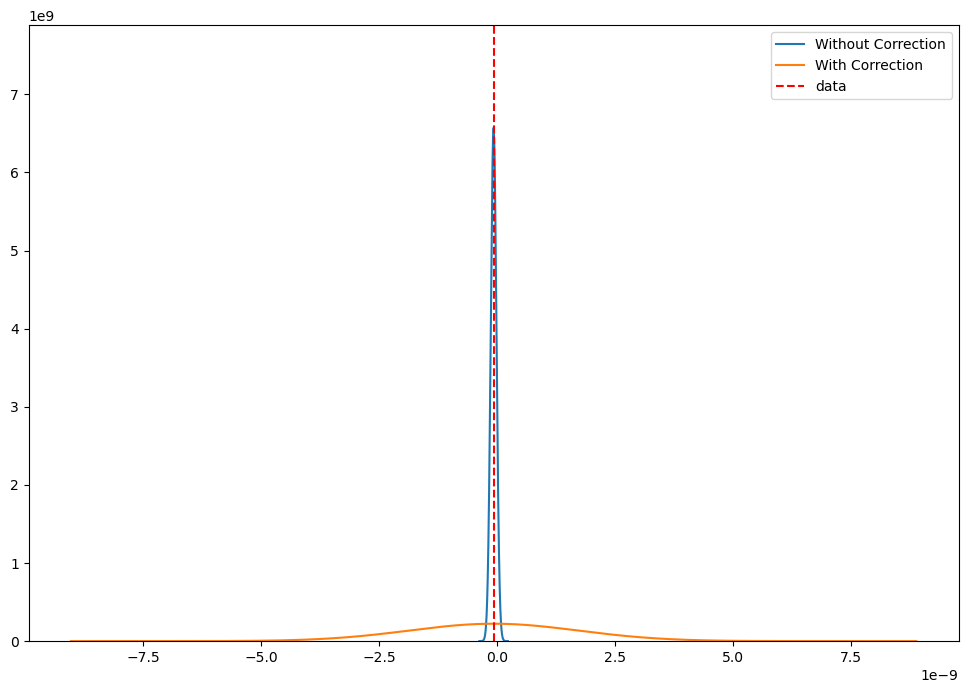

In [394]:
plt.figure(figsize=(12,8))
plt.plot(g1, pdf1, label = 'Without Correction')
plt.plot(g2, pdf2, label = 'With Correction')
plt.axvline(mu, linestyle = '--', c = 'r', label = 'data')
plt.ylim(0.0, 1.2*max([max(pdf1), max(pdf2)]))
plt.legend()
plt.show()

In [395]:
errfunc1 = error_function(g1[g1>=0], std)
errfunc2 = error_function(g2[g2>=0], std_c)

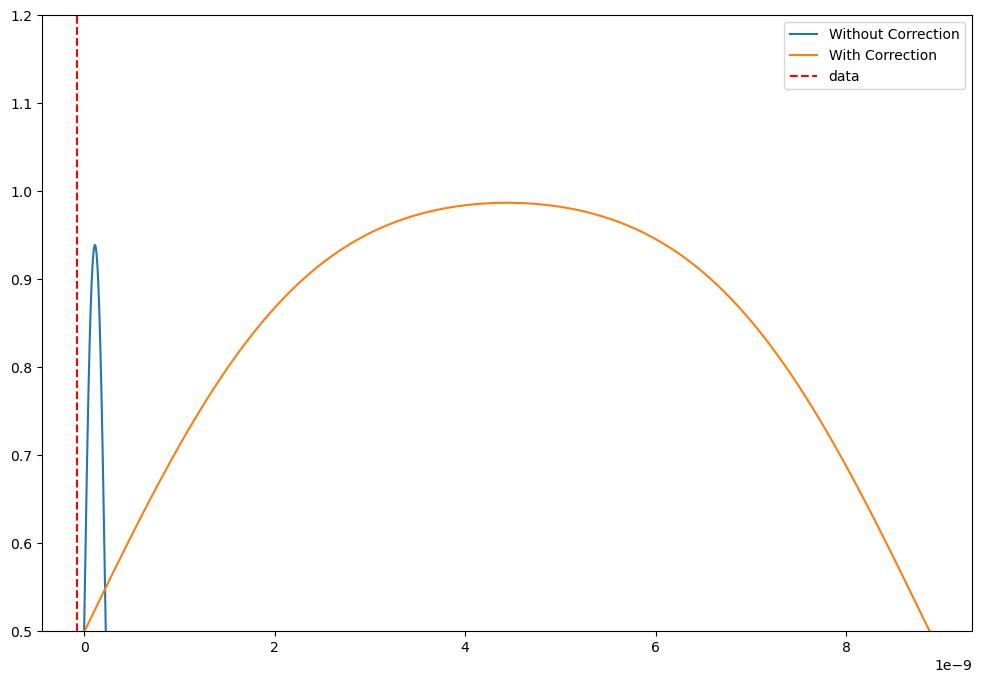

In [398]:
plt.figure(figsize=(12,8))
plt.plot(g1[g1>=0],  errfunc1, label = 'Without Correction')
plt.plot(g2[g2>=0], errfunc2, label = 'With Correction')
plt.axvline(mu, linestyle = '--', c = 'r', label = 'data')
plt.ylim(0.5, 1.2)
plt.legend()
plt.show()

Plot the fluxes

In [30]:
labels = [r'$u$', r'$g$', r'$r$', r'$i$', r'$Z$', r'$Y$', r'$J$', r'$H$', r'$K_{s}$']

Number of objects with valid (positive) flux is 3916
Number of objects with valid (positive) flux is 4919
Number of objects with valid (positive) flux is 5000
Number of objects with valid (positive) flux is 4912
Number of objects with valid (positive) flux is 4988
Number of objects with valid (positive) flux is 4932
Number of objects with valid (positive) flux is 4967
Number of objects with valid (positive) flux is 4724
Number of objects with valid (positive) flux is 4784


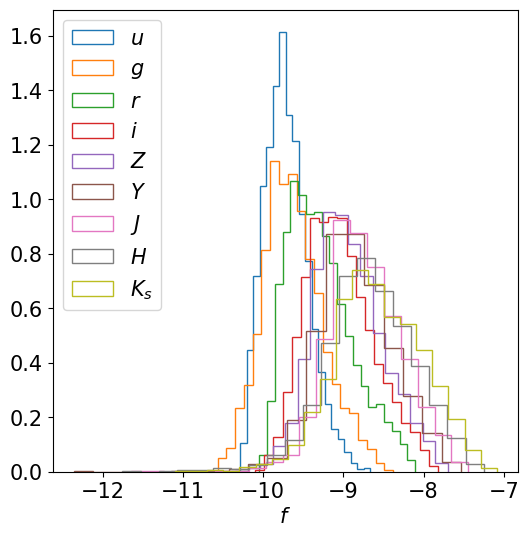

In [31]:
plt.figure(figsize=(6, 6))
for i in range(9):
    fluxvalues = test_flux.values[:,i][test_mag.values[:,i] != 99.0]
    print(f'Number of objects with valid (positive) flux is {fluxvalues.shape[0]}')
    plt.hist(np.log10(fluxvalues), density=True, bins=20, histtype='step', label = f'{labels[i]}')
plt.xlabel(r'$f$', fontsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
# plt.savefig('/home/harry/Desktop/scaled_flux.pdf', bbox_inches = 'tight')
plt.show()

# Filters

In [91]:
from typing import Tuple

In [165]:
def get_filters(folder: str, filternames: list) -> Tuple[dict, dict, dict]:
    """
    Get the filters to be used to calculate the flux.

    Args:
        folder (str): folder where the filters are stored.
        
        filternames (list): name of all the filters

    Returns:
        Tuple[dict, dict, dict]: the filter, its wavelength range, the minimum and maximum wavelength.
    """
    record = dict()
    record_wavelength = dict()
    record_minmax = dict()

    for f in filternames:
        data = np.genfromtxt(os.path.join(folder, f'{f}.res'))
        wavelength, filt = data[:, 0], data[:, 1]
        if f in ['Z', 'Y', 'J', 'H', 'Ks']:
            wavelength *= 10 # because the units are in micron instead of angstrom
        
        condition = wavelength > 2500
        wavelength = wavelength[condition]
        filt = filt[condition]
        
        # the filter is divided by wavelength here
        filt /= wavelength
        norm = np.trapz(filt, wavelength)
        filt /= norm

        # find minimum and maximum wavelength
        ind = np.where(filt > 0.01 * np.max(filt))[0]
        lambda_min, lambda_max = wavelength[ind[0]], wavelength[ind[-1]]

        record[f.split(".")[0]] = filt
        record_minmax[f.split(".")[0]] = [lambda_min, lambda_max]
        record_wavelength[f.split(".")[0]] = wavelength

    return record, record_wavelength, record_minmax

In [191]:
def get_seds(folder: str, waveref: float = 4e5) -> dict:
    """
    Get the SEDs from the folder and the SEDs are normalised at a particular wavelength.

    Args:
        folder (str): folder where the SEDs are stored.
        waveref (float, optional): the wavelength at which the SEDs are standardised. Defaults to 4e5.

    Returns:
        dict: dictionary with the standardised SEDs.
    """
    sednames = os.listdir(folder)
    seds = dict()
    for i, t in enumerate(sednames):
        seddata = np.genfromtxt(f"{folder}/{t}")
        seddata[:, 1] *= seddata[:, 0] ** 2.0 / 3e18
        ref = np.interp(waveref, seddata[:, 0], seddata[:, 1])
        seddata[:, 1] /= ref
        seds[t.split(".")[0]] = seddata
    return seds

In [192]:
seds = get_seds('seds')

In [167]:
filters, filterwave, filterwaverange = get_filters('filters', CONFIG.band)

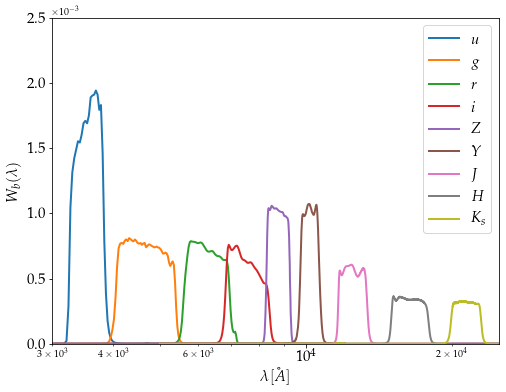

In [374]:
plt.figure(figsize = (8,6))
for i, key in enumerate(CONFIG.band):
    plt.plot(filterwave[key], filters[key], lw = 2, label = labels[i])
plt.xlim(3000, 2.5E4)
plt.ylim(0, 0.0025)
plt.ylabel(r'$W_b(\lambda)$', fontsize=15)
plt.xlabel(r'$\lambda [\AA]$', fontsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.xscale('log')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
# plt.savefig('/home/harry/Desktop/filters.pdf', bbox_inches = 'tight')
plt.show()

In [187]:
def approx_lum_dist(redshift: float) -> float:
    """
    Calculates the approximate luminosity distance given a redshift.

    Args:
        redshift (float): the redshift value.

    Returns:
        float: the approximate luminosity distance.
    """
    return np.exp(30.5 * redshift**0.04 - 21.7)

In [188]:
def get_flux(
    filters: dict, wavelengths: dict, lambdaminmax: dict, seds: dict, redshift: float
) -> pd.DataFrame:
    """
    Calculate the theoretical flux. The output is a dataframe of size Nt x Nf,
    where Nt is the number of templates and Nf is the number of filters.

    Args:
        filters (dict): a dictionary of filters.
        wavelengths (dict): a dictionary of the wavelength range.
        lambdaminmax (dict): the minimum and maximum of wavelength.
        seds (dict): a dictionary with all the SEDs/templates.
        redshift (float): the redshift value.

    Returns:
        pd.DataFrame: a dataframe of fluxes for Nt templates and Nf filters.
    """
    scaled_redshift = 1.0 + redshift
    nfilters = len(filters)
    nseds = len(seds)

    # calculate pre-factor
    lum_dist = approx_lum_dist(redshift)
    prefactor = scaled_redshift**2 / (4.0 * np.pi * lum_dist**2)

    # empty array to store the fluxes
    record_fluxes = dict()

    for i, s in enumerate(seds):
        fluxes = np.zeros(nfilters)
        for j, f in enumerate(filters):
            wave_grid = np.linspace(
                lambdaminmax[f][0] / scaled_redshift,
                lambdaminmax[f][1] / scaled_redshift,
                5000,
            )
            filter_interp = interp1d(wavelengths[f] / scaled_redshift, filters[f])
            sed_interp = interp1d(seds[s][:, 0], seds[s][:, 1])
            filter_new = filter_interp(wave_grid)
            sed_new = sed_interp(wave_grid)
            fluxes[j] = prefactor * np.trapz(sed_new * filter_new, wave_grid)
        record_fluxes[s] = fluxes
    record_fluxes = pd.DataFrame(record_fluxes).T
    record_fluxes.columns = filters.keys()
    return record_fluxes

In [220]:
theory_flux = get_flux(filters, filterwave, filterwaverange, seds, 1.0)

In [221]:
theory_flux

,u,g,r,i,Z,Y,J,H,Ks
Im_B2004a,7.098853e-10,8.095591e-10,9.628013e-10,1.575225e-09,2.202935e-09,2.847287e-09,3.040785e-09,3.672563e-09,4.407923e-09
ssp_5Myr_z008,1.494386e-05,1.281550e-05,9.989135e-06,9.206243e-06,8.613740e-06,6.834048e-06,5.407470e-06,3.918562e-06,2.819263e-06
Scd_B2004a,4.400613e-10,5.473817e-10,8.416051e-10,1.494811e-09,2.486833e-09,3.289377e-09,4.399265e-09,5.341645e-09,6.428417e-09
ssp_25Myr_z008,1.022012e-06,9.594426e-07,8.517016e-07,9.414737e-07,1.127013e-06,1.013883e-06,9.978718e-07,1.009470e-06,1.090609e-06
El_B2004a,3.267202e-11,1.028649e-10,9.177936e-10,2.254420e-09,5.645746e-09,9.086690e-09,1.508772e-08,2.284197e-08,2.995069e-08
Sbc_B2004a,1.241417e-10,1.938843e-10,3.780160e-10,9.458631e-10,1.775450e-09,2.432129e-09,3.608660e-09,5.080588e-09,7.513007e-09
SB3_B2004a,2.543377e-09,2.846407e-09,3.613912e-09,5.081096e-09,8.091822e-09,9.554061e-09,1.329188e-08,1.577905e-08,2.070195e-08
SB2_B2004a,6.207456e-09,6.273813e-09,7.315345e-09,1.034724e-08,1.235894e-08,1.974206e-08,1.838557e-08,1.825236e-08,1.897642e-08


In [196]:
test_mag.iloc[0]

MAG_GAAP_u     99.000000
MAG_GAAP_g     24.546875
MAG_GAAP_r     24.421875
MAG_GAAP_i     23.921875
MAG_GAAP_Z     23.718750
MAG_GAAP_Y     23.093750
MAG_GAAP_J     24.109375
MAG_GAAP_H     22.593750
MAG_GAAP_Ks    22.578125
Name: 0, dtype: float16

In [197]:
test_flux.iloc[0]

FLUX_GAAP_u     1.056200e-11
FLUX_GAAP_g     1.392500e-10
FLUX_GAAP_r     1.615300e-10
FLUX_GAAP_i     2.616000e-10
FLUX_GAAP_Z     3.160200e-10
FLUX_GAAP_Y     5.578200e-10
FLUX_GAAP_J     2.218589e-10
FLUX_GAAP_H     9.050900e-10
FLUX_GAAP_Ks    9.245900e-10
Name: 0, dtype: float32

In [198]:
test_flux_err.iloc[0]

FLUXERR_GAAP_u     6.540000e-11
FLUXERR_GAAP_g     2.810000e-11
FLUXERR_GAAP_r     3.120000e-11
FLUXERR_GAAP_i     7.300000e-11
FLUXERR_GAAP_Z     1.610000e-10
FLUXERR_GAAP_Y     3.810000e-10
FLUXERR_GAAP_J     4.248053e-10
FLUXERR_GAAP_H     1.030000e-09
FLUXERR_GAAP_Ks    9.430000e-10
Name: 0, dtype: float32

In [226]:
theory_flux.iloc[0]

u     7.098853e-10
g     8.095591e-10
r     9.628013e-10
i     1.575225e-09
Z     2.202935e-09
Y     2.847287e-09
J     3.040785e-09
H     3.672563e-09
Ks    4.407923e-09
Name: Im_B2004a, dtype: float64

In [348]:
def calculate_loglike_single(data: np.ndarray, theory: np.ndarray, sigma: np.ndarray, magnitudes: np.ndarray):
    
    loglike = 0.0
    nband = len(data)
    for i in range(nband):
        if magnitudes[i] == 99.0:
            logfunc = calculate_erfc(theory[i], sigma[i])
        else:
            normal = ss.norm(theory[i], sigma[i])
            logfunc = normal.logpdf(data[i])
        loglike += logfunc
    return loglike

In [349]:
index = 0

In [350]:
calculate_loglike_single(test_flux.iloc[index].values, theory_flux.iloc[index].values, 
                         test_flux_err.iloc[index].values, test_mag.iloc[index].values)

-723.9619384756147

## Understand Error Function

In [34]:
import scipy.stats as ss 
from scipy.special import erf, erfc, erfcx
from scipy.stats import norm

def error_function(theory, sigma):
    lower = -5.0 * sigma
    upper = 5.0 * sigma
    factor_lower = (lower - theory) / (sigma * np.sqrt(2))
    factor_upper = (upper - theory) / (sigma * np.sqrt(2))
    erf_func = 0.5 * (erf(factor_upper) - erf(factor_lower))
    return erf_func

In [35]:
sigma = 3.0
nfact = 2.0
lower = -5.0 * sigma
upper = 5.0 * sigma
theory = np.linspace(nfact*lower, nfact*upper, 500)

In [36]:
pdf = ss.norm(0.0, sigma).pdf(theory)
erf_function = error_function(theory, sigma)
erf_function /= np.trapz(erf_function, theory)

<Figure size 640x480 with 0 Axes>

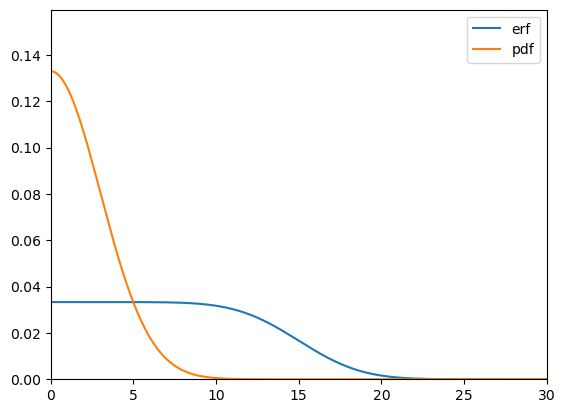

In [37]:
plt.figure()
plt.plot(theory, erf_function, label = r'erf')
plt.plot(theory, pdf, label = r'pdf')
plt.xlim(0, nfact*upper)
plt.ylim(0.0, 1.2*max([max(pdf), max(erf_function)]))
plt.legend()
# plt.savefig('/home/harry/Desktop/test_sigma_equal_three.pdf', bbox_inches = 'tight')
plt.show()

# Error Functions
- normal
- erf
- erfc

In [22]:
grid = np.linspace(-5, 5, 1000)
dist = norm(0, 1)
ypdf = dist.pdf(grid)
yerf = erf(grid)
yerfc = erfc(grid)

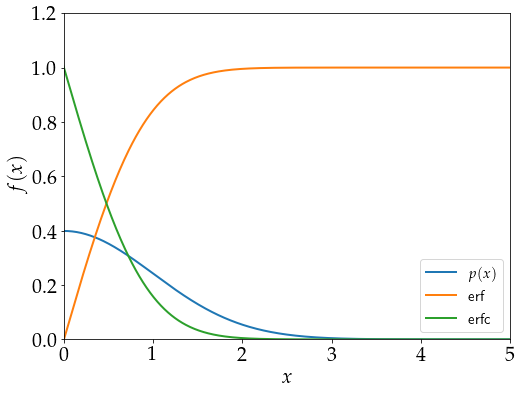

In [92]:
plt.figure(figsize=(8,6))
plt.plot(grid, ypdf, lw=2, label = r'$p(x)$')
plt.plot(grid, yerf, lw=2, label = 'erf')
plt.plot(grid, yerfc, lw=2, label = 'erfc')
plt.ylabel(r'$f(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.xlim(0,max(grid))
plt.ylim(0.0, 1.2)
plt.show()

Example of magnitude with mean = 99 and error = 6.722656. 

Some relations between the cumulative distribution function, $\Phi$ and the error function, $\texttt{erf}$ (and complementary error function, $\texttt{erfc}$) are given below:

$$\texttt{erf}(x)=2\Phi(\sqrt{2}x)-1$$

$$\texttt{erfc}(x)=2\Phi_{c}(\sqrt{2}x)$$

where $\Phi_{c}(x)=1-\Phi(x)$ or we can simply use the relation $\texttt{erfc}(x)=1 - \texttt{erf}(x)$.

In [86]:
value = 99
error = 6.722656
mag_dist = norm(value, error)
mag_grid = np.linspace(15, value + 5*error, 1000)
mag_pdf = mag_dist.pdf(mag_grid)
mag_cdf = mag_dist.cdf(mag_grid)

In [87]:
mag_erf = 2 * mag_dist.cdf(np.sqrt(2) * mag_grid) - 1
mag_erfc = 1 - mag_erf

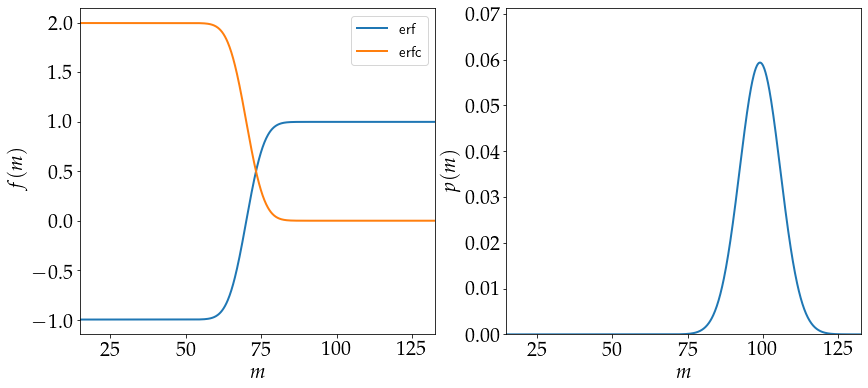

In [108]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(mag_grid, mag_erf, lw=2, label = 'erf')
plt.plot(mag_grid, mag_erfc, lw=2, label = 'erfc')
plt.ylabel(r'$f(m)$', fontsize = fontSize)
plt.xlabel(r'$m$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.xlim(min(mag_grid), max(mag_grid))

plt.subplot(122)
plt.plot(mag_grid, mag_pdf, lw=2, label = r'$p(m)$')
plt.ylabel(r'$p(m)$', fontsize = fontSize)
plt.xlabel(r'$m$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 1.2*max(mag_pdf))
plt.xlim(min(mag_grid), max(mag_grid))
plt.show()

In [70]:
f_example = df_flux.iloc[0].values
ferr_example = df_flux_err.iloc[0].values

mag_example = df_mag.iloc[0].values
magerr_example = df_magerr.iloc[0].values

maglim_example = df_mag_lim.iloc[0].values

In [71]:
fcorr = np.copy(f_example)
ferrcorr = np.copy(ferr_example)

In [72]:
fcorr[4:] *= 1E-12
ferrcorr[4:] *= 1E-12

In [73]:
f_example

array([1.056200e-11, 1.392500e-10, 1.615300e-10, 2.616000e-10,
       3.160200e+02, 5.578200e+02, 2.218589e+02, 9.050900e+02,
       9.245900e+02], dtype=float32)

In [74]:
ferr_example

array([6.540000e-11, 2.810000e-11, 3.120000e-11, 7.300000e-11,
       1.610000e+02, 3.810000e+02, 4.248053e+02, 1.030000e+03,
       9.430000e+02], dtype=float32)

In [75]:
fcorr

array([1.056200e-11, 1.392500e-10, 1.615300e-10, 2.616000e-10,
       3.160200e-10, 5.578200e-10, 2.218589e-10, 9.050900e-10,
       9.245900e-10], dtype=float32)

In [76]:
ferrcorr

array([6.540000e-11, 2.810000e-11, 3.120000e-11, 7.300000e-11,
       1.610000e-10, 3.810000e-10, 4.248053e-10, 1.030000e-09,
       9.430000e-10], dtype=float32)

In [77]:
mag_example

array([99.  , 24.55, 24.42, 23.92, 23.72, 23.1 , 24.11, 22.6 , 22.58],
      dtype=float16)

In [78]:
magerr_example

array([6.723 , 0.2191, 0.2097, 0.303 , 0.553 , 0.7417, 2.078 , 1.235 ,
       1.107 ], dtype=float16)

In [79]:
maglim_example

array([25.5 , 26.39, 26.28, 25.36, 24.48, 23.55, 23.42, 22.47, 22.56],
      dtype=float16)

In [55]:
ferrcorr/fcorr

array([6.192009  , 0.20179532, 0.19315298, 0.279052  , 0.50946146,
       0.683016  , 1.9147544 , 1.1380084 , 1.0199115 ], dtype=float32)

In [94]:
index = 0
value = fcorr[index]
error = ferrcorr[index]
flux_dist = norm(value, error)
flux_grid = np.linspace(value - 5*error, value + 5*error, 1000)
flux_pdf = flux_dist.pdf(flux_grid)
flux_cdf = flux_dist.cdf(flux_grid)
flux_erf = 2 * flux_dist.cdf(np.sqrt(2) * flux_grid) - 1
flux_erfc = 1 - flux_erf

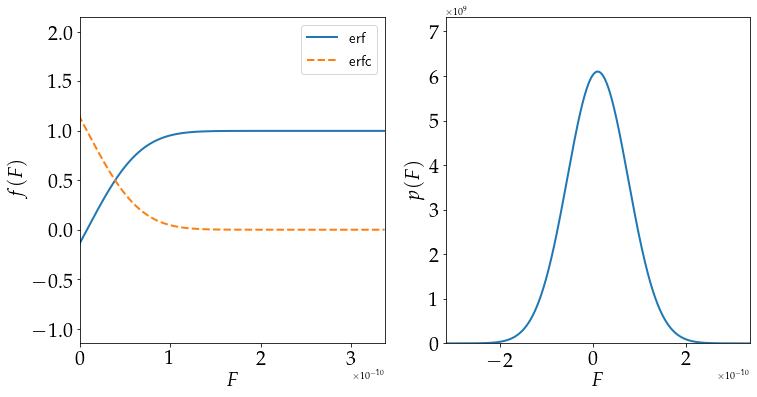

In [103]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(flux_grid, flux_erf, lw=2, label = 'erf')
plt.plot(flux_grid, flux_erfc, lw=2, label = 'erfc', linestyle = '--')
plt.ylabel(r'$f(F)$', fontsize = fontSize)
plt.xlabel(r'$F$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.xlim(0, max(flux_grid))
plt.subplot(122)
plt.plot(flux_grid, flux_pdf, lw=2, label = r'$p(F)$')
plt.ylabel(r'$p(F)$', fontsize = fontSize)
plt.xlabel(r'$F$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(flux_grid), max(flux_grid))
plt.ylim(0, 1.2*max(flux_pdf))
plt.show()

## Condition 1 

All values of magnitude should be less than the magnitude limit. If all the values of magnitude is less than the magnitude limit, then we keep that row (and is denoted by a 1). 

In [22]:
condition_1 = np.sum((df_mag.values < df_mag_lim.values)*1, axis = 1)
condition_1 = (condition_1 == 9) * 1 

## Apply Corrections

In [163]:
test_mag = df_mag[condition_1 == 1].values
test_mag_err = df_magerr[condition_1 == 1].values
test_flux = df_flux[condition_1 == 1].values
test_flux_err = df_flux_err[condition_1 == 1].values
test_ext = df_ext[condition_1 == 1].values
test_names = df_names[condition_1 == 1].values.reshape(-1)
test_redshifts = df_redshifts[condition_1 == 1].values

In [186]:
test_mag.shape[0]

14674588

In [187]:
df_mag.shape[0]

21262011

In [191]:
print(f'Fraction of data being used is: {test_mag.shape[0]/df_mag.shape[0]:.3f}')

Fraction of data being used is: 0.690


In [204]:
def calculate_corrections(magnitudes, magnitudes_error, flux, flux_error, extinction, names, redshifts):
    unique_names = np.unique(names)
    nunique = len(unique_names)
    print(f'Number of patches is: {nunique}')
    patches = dict()
    for i in range(5):
        record = dict()
        patch = names == unique_names[i]
        record['magnitudes'] = magnitudes[patch] - extinction[patch]
        record['magnitudes_err'] = magnitudes_error[patch]
        scaled_magnitude = magnitudes[patch] + 2.5 * np.log10(flux[patch])
        correction = 10**(0.4*extinction[patch]) * 10**(-0.4 * np.median(scaled_magnitude, axis = 0))
        record['flux_corr'] = flux[patch] * correction
        record['flux_err_corr'] = flux_error[patch] * correction
        record['redshifts'] = redshifts[patch]
        patches[unique_names[i]] = record
    return patches

In [ ]:
patches = calculate_corrections(test_mag, test_mag_err, test_flux, test_flux_err, test_ext, test_names, test_redshifts)

In [176]:
patches.keys()

dict_keys(['KIDS_0p0_m28p2', 'KIDS_0p0_m29p2', 'KIDS_0p0_m30p2', 'KIDS_0p0_m31p2', 'KIDS_0p0_m32p1'])

In [193]:
# import utils.helpers as hp
# hp.pickle_save(patches, './', 'testing')

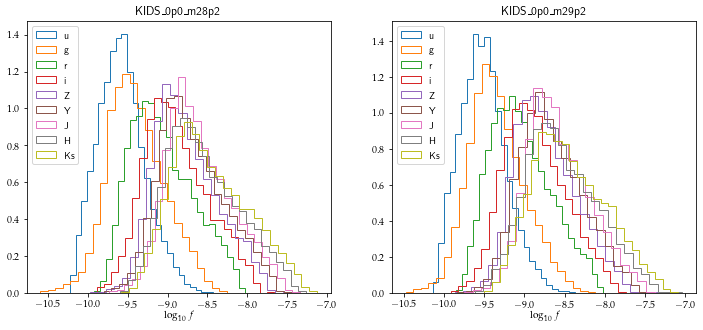

In [197]:
plt.figure(figsize = (12,5))
plt.subplot(121)
plt.title('KIDS\_0p0\_m28p2')
for i in range(9):
    plt.hist(np.log10(patches['KIDS_0p0_m28p2']['flux_corr'][:,i]), density = True, bins=25, histtype='step', label = CONFIG.band[i])
plt.xlabel(r'$\textrm{log}_{10}\;f$')
plt.legend()
plt.subplot(122)
plt.title('KIDS\_0p0\_m29p2')
for i in range(9):
    plt.hist(np.log10(patches['KIDS_0p0_m29p2']['flux_corr'][:,i]), density = True, bins=25, histtype='step', label = CONFIG.band[i])
plt.xlabel(r'$\textrm{log}_{10}\;f$')    
plt.legend()
plt.show()

# Position on Sky

In [ ]:
xarr, yarr = data['ALPHA_J2000'], data['DELTA_J2000']
nobjects = 1000000
idx = random.sample(range(len(xarr)), nobjects)
eq = SkyCoord(xarr[idx], yarr[idx], unit=u.deg)
gal = eq.galactic
colors = np.random.random((nobjects, 3))

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=10, c=colors, alpha=0.6, edgecolors=colors, rasterized=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('plots/skymap.pdf', bbox_inches = 'tight')
plt.show()

# Processing

Process the data in such as way that we have 6 files stored 

- flux 
- flux errors 
- magnitude
- magnitude error 
- BPZ 
- meta data 

We can process the whole data and this will be stored in data/processed or we can take a subset of $N$ galaxies and these will be stored in data/sets.

In [2]:
from src.processing import cleaning 

In [ ]:
fits_image = fits.open('data/catalogue/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits')

# cleaning  (done once)
# whole_data = cleaning(fits_image, save = True, folder = 'data/processed')

print('-'*50)
for i in range(5):
    set_galaxies = cleaning(fits_image, save = True, ngalaxies = 100, folder = f'data/sets/set_{i+1}')
    print('-'*50)

fits_image.close()

# Tomography

In [2]:
from src.stackz import stack_fitting, stack_predictions
import utils.helpers as hp

In [26]:
BANDWIDTH = 0.05

### Fitting

In [27]:
## Done Once (because the KDEs are then stored)
bpz_redshifts = hp.pickle_load('data/processed', 'bpz')['Z_B']
kdes = stack_fitting(bpz_redshifts.values, save=True, bandwidth=BANDWIDTH, ngalaxies=100000)

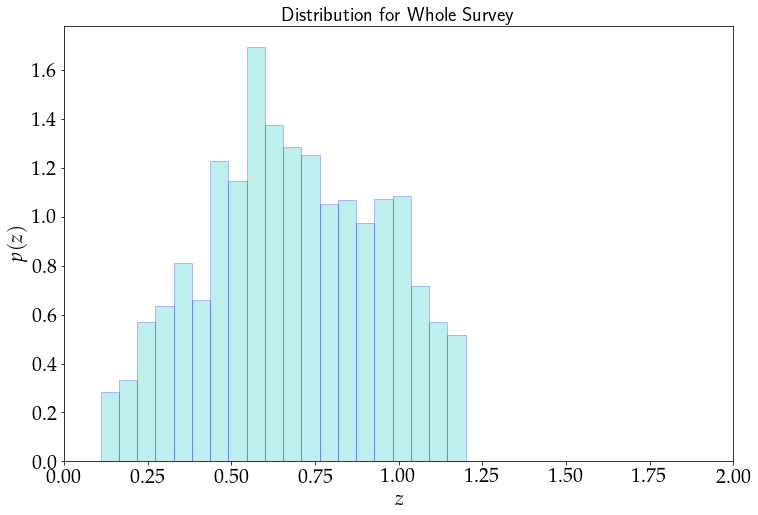

In [40]:
plt.figure(figsize = (12, 8))
plt.title('Distribution for Whole Survey', fontsize=fontSize)
plt.hist(bpz_redshifts, density = True, bins = 20, color='c', edgecolor='b', alpha=0.25)
plt.ylabel(r'$p(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(0.0, 2.0)
# plt.savefig('plots/KiDS_1000_full_survey_distribution.pdf', bbox_inches = 'tight')
plt.show()

### Prediction - Smooth Distribution

In [28]:
redshift_range = np.linspace(0, 2, 1000)
smooth_pdf = stack_predictions(redshift_range, bandwidth=BANDWIDTH, save = False, fname = None)

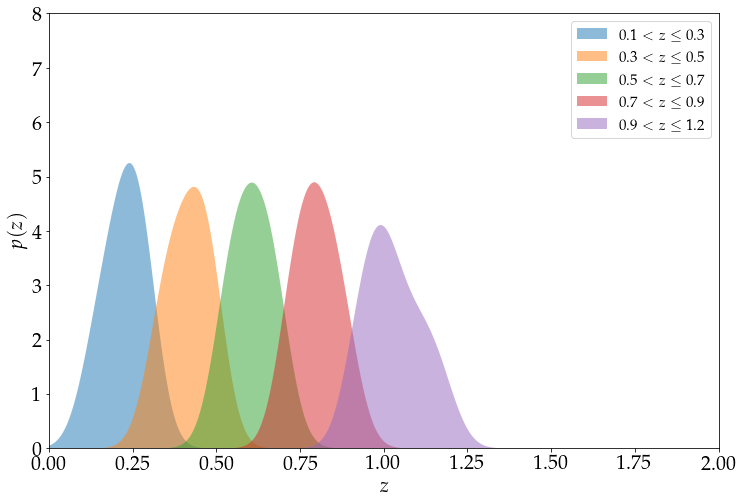

In [29]:
plt.figure(figsize = (12, 8))
plt.fill_between(redshift_range, smooth_pdf['h1'], alpha=0.5, label = r'$0.1<z\leq 0.3$')
plt.fill_between(redshift_range, smooth_pdf['h2'], alpha=0.5, label = r'$0.3<z\leq 0.5$')
plt.fill_between(redshift_range, smooth_pdf['h3'], alpha=0.5, label = r'$0.5<z\leq 0.7$')
plt.fill_between(redshift_range, smooth_pdf['h4'], alpha=0.5, label = r'$0.7<z\leq 0.9$')
plt.fill_between(redshift_range, smooth_pdf['h5'], alpha=0.5, label = r'$0.9<z\leq 1.2$')
plt.ylabel(r'$p(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 8.0)
plt.xlim(0.0, 2.0)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
# plt.savefig(f'plots/stack_redshift_{BANDWIDTH}.pdf', bbox_inches = 'tight')
plt.show()

### Prediction - KiDS-1000 Mid-Redshifts

In [30]:
# load the fits file
data_tables = fits.open('data/cosmology/kids_1000.fits')

# extract the n(z) distribution
nofz = data_tables['NZ_SOURCE'].data

# get the redshifts
z_mid = np.concatenate((np.zeros(1), nofz['Z_MID']))

In [31]:
kids_pdf = stack_predictions(z_mid, bandwidth=BANDWIDTH, save = True, fname = f'kids_1000_{BANDWIDTH}')

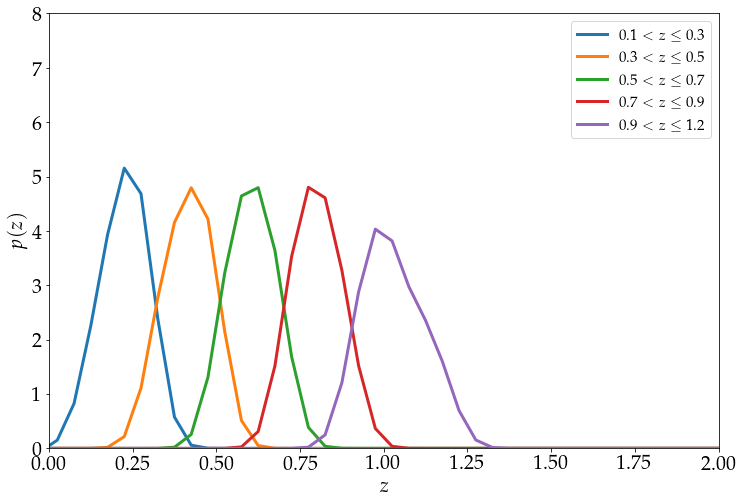

In [32]:
plt.figure(figsize=(12,8))
plt.plot(z_mid, kids_pdf['h1'], lw = 3, label = r'$0.1<z\leq 0.3$')
plt.plot(z_mid, kids_pdf['h2'], lw = 3, label = r'$0.3<z\leq 0.5$')
plt.plot(z_mid, kids_pdf['h3'], lw = 3, label = r'$0.5<z\leq 0.7$')
plt.plot(z_mid, kids_pdf['h4'], lw = 3, label = r'$0.7<z\leq 0.9$')
plt.plot(z_mid, kids_pdf['h5'], lw = 3, label = r'$0.9<z\leq 1.2$')
plt.ylabel(r'$p(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(0.0, 2.0)
plt.ylim(0.0, 8.0)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
# plt.savefig(f'plots/kids_1000_{BANDWIDTH}.pdf', bbox_inches = 'tight')
plt.show()

In [33]:
def testing(a, b, **kwargs):
    
    print('Value' in kwargs)
    print(kwargs.values())
    
    val = kwargs.pop('value')
    ans = a + b + val 
    return ans 

In [34]:
testing(2, 3, value = 10)

False
dict_values([10])


15